<font size=6><center> Machine Learning - Assignment 1 </center></font>

<font size=5><center> First dataset: Bank Customer Churn </center></font>

<font size="4"><center>Author: Mohamed Amine DASSOULI </center></font>

<font size=6> Table of contents: </font>

1. [Importations](#1)
1. [Configuration](#2)
1. [Functions](#3)
1. [Visualizing data](#4)
1. [Data preprocessing](#5)
1. [Prediction models](#6)
    * [Decision Trees](#7)
    * [Artificial Neural Network](#8)
    * [Boosting](#9)
    * [Support Vector Machine](#10)
    * [k-Nearest neighbors](#11)
1. [Comparing the results](#12)

<a id='1'></a>
# Importations

In [440]:
import pandas as pd
import numpy as np 

from numpy.random import seed


%matplotlib inline
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline, BSpline

from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

<a id='2'></a>
# Configuration

In [2]:
PATH_CSV_DATA = "Data/Churn_Modelling.csv"

<a id='3'></a>
# Functions

In [3]:
def encode_column(col: np.ndarray, max_unique_values: int = 100) -> np.ndarray:
    """
    Encode a numpy array
    
    Parameters
    ----------
    col : numpy 1D-Array
    max_unique_values : int, default 100
        Limit the number of unique values to use
        Take the most occurents and regroup all the others in one value

    Returns
    -------
    numpy 2D-Array
        Encoded Array
    
    
    """
    # Get the unique values and their frequences in the list
    col_values = np.unique(col, return_counts=True)
    
    # If there are only two unique values, we use a labelencoder, otherwise we use a onehotencoder
    n_unique_values = len(col_values[0]) 
    if n_unique_values <=2 : 
        labelencoder = LabelEncoder()
        encoded_col = labelencoder.fit_transform(col.reshape((len(col), 1)))
    else:
        # Find the `max_unique_values` most occurent unique values in the column
        col_values = [(val,freq) for (val,freq) in zip(col_values[0], col_values[1])]
        col_values.sort(key=lambda x: x[1])
        values_keep = [col_values[i][0] for i in range(min(max_unique_values, n_unique_values))]
        
        # Keep the most occurent unique values, and change all the others to a value "Others"
        col = np.array([value if value in values_keep else "Others" for value in col])
        
        # Use a hot encoder
        onehotencoder = OneHotEncoder()
        encoded_col = onehotencoder.fit_transform(col.reshape((len(col), 1))).toarray()
    
    return encoded_col

In [434]:
def training_curve(name_model, X_train, y_train, X_test, y_test, num_points=10, smallest_size=5, metric="acc", 
                   smooth=False, title=""):
    # Get number of samples in the training data
    n_samples = X_train.shape[0]
    
    # Initiate the lists that are going to be used for plotting the curve
    curve_X = []
    curve_Y_train = []
    curve_Y_test = []
    curve_loss_train = []
    curve_loss_test = []
    
    for i in np.linspace(smallest_size, n_samples, num_points):
        # Define model
        if name_model == "svm_rbf":
            model_i = svm.SVC(kernel='rbf', gamma=0.1, C=5, random_state=33, probability=True) 
        elif name_model == "svm_poly":
            model_i = svm.SVC(kernel='poly', gamma=0.1, C=1, degree=5, coef0=2, random_state=33, probability=True)  
        elif name_model == "dt":
            model_i = DecisionTreeClassifier(max_depth=6, random_state=13)
        elif name_model == "dt_gini":
            model_i = DecisionTreeClassifier(max_depth=13, random_state=1, min_samples_split=2, criterion="gini")
        elif name_model == "dt_entropy":
            model_i = DecisionTreeClassifier(max_depth=13, random_state=1, min_samples_split=2, criterion="entropy")
        elif name_model == "knn_manhattan":
            model_i = KNeighborsClassifier(n_neighbors=20, p=1)
        elif name_model == "knn_euclidean":
            model_i = KNeighborsClassifier(n_neighbors=20, p=2)
        elif name_model == "knn_minkowski3":
            model_i = KNeighborsClassifier(n_neighbors=20, p=3)
            
        # Fit it using a partition of X_train, y_train
        X_train_i = X_train[:int(i),]
        y_train_i = y_train[:int(i)]
        model_i.fit(X_train_i, y_train_i.astype(int))
        
        # Make prediction on the train set
        y_proba_train = model_i.predict_proba(X_train)
        y_pred_train = (y_proba_train[:,1] >= 0.5).astype(int)
        
        # Make prediction on the test set
        y_proba_test = model_i.predict_proba(X_test)
        y_pred_test = (y_proba_test[:,1] >= 0.5).astype(int)
        
        # Compute metric
        if metric == "acc":
            metric_i = accuracy_score(y_test.astype(int), y_pred.astype(int))
        elif metric == "bal_acc":
            metric_i_train = balanced_accuracy_score(y_train.astype(int), y_pred_train.astype(int))
            metric_i_test = balanced_accuracy_score(y_test.astype(int), y_pred_test.astype(int))
        
        # Compute loss
            loss_i_train = log_loss(y_train.astype(int), y_proba_train)
            loss_i_test = log_loss(y_test.astype(int), y_proba_test)
            print(i/n_samples)
        
        # Store the result
        curve_X.append(i/n_samples)
        curve_Y_train.append(metric_i_train)
        curve_Y_test.append(metric_i_test)
        curve_loss_train.append(loss_i_train)
        curve_loss_test.append(loss_i_test)

    # Plot the curve for balanced_accuracy_metric
    plt.figure(figsize=(12,8))
    plt.plot(curve_X, curve_Y_train, label="Training set")
    plt.plot(curve_X, curve_Y_test, label="Testing set")
    plt.xlabel("Percentage of the training set used", {"size": 14})
    plt.ylabel("Balanced_accuracy", {"size": 14})
    
    plt.title(title)
    
    plt.legend()
    
    # Plot the curve for the loss
    plt.figure(figsize=(12,8))
    plt.plot(curve_X, curve_loss_train, label="Training")
    plt.plot(curve_X, curve_loss_test, label="Testing")
    plt.xlabel("Percentage of the training set used", {"size": 14})
    plt.ylabel("Cross-entropy Loss", {"size": 14})
    plt.legend()
    

<a id='4'></a>
# Visualizing data

In [9]:
# Loading data 
df_data = pd.read_csv(PATH_CSV_DATA, )

# View the dataframe
df_data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,233.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


### Basic information

In [6]:
# Visualize basic information about the data
print(f"- Data shape : {df_data.shape}\n")
print(f"- Keys :\n\n{df_data.dtypes}")

- Data shape : (10000, 14)

- Keys :

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


### Missing data

In [13]:
# Check if there is any missing data 
df_data.isna().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

<font size="3"> ==> There is not any NaN cell. Therefore, there is no missing data ! </font>

### Data balancing

<font size="3"> Let's look at the data and check if there is any imbalance </font>


In [53]:
# Calculate the number of clients who exited the bank
num_samples = df_data.shape[0]
classes = pd.value_counts(df_data["Exited"])

print(f"Number of people who exited : {classes[1]} | Percentage : {100 * classes[1] / num_samples} %")
print(f"Number of people who stayed : {classes[0]} | Percentage : {100 * classes[0] / num_samples} %")

Number of people who exited : 2037 | Percentage : 20.37 %
Number of people who stayed : 7963 | Percentage : 79.63 %


([<matplotlib.patches.Wedge at 0x7f48132d21d0>,
 [Text(-0.8823431426537007, 0.6568642010431011, 'Stayed'),
  Text(0.8823431426537006, -0.6568642010431012, 'Left')],
 [Text(-0.48127807781110943, 0.3582895642053278, '79.63%'),
  Text(0.4812780778111093, -0.35828956420532787, '20.37%')])

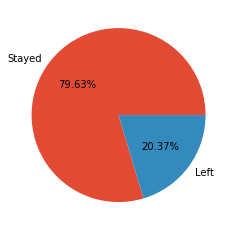

In [52]:
plt.pie(classes.values[:], labels=["Stayed", "Left"], autopct=lambda p: f"{p:.2f}%")

<font size='3'> ==> 20 % | 80 % ratio can have an impact on the performance. Thus, we will probably have to resample. </font>

<a id='5'></a>
# Data Preprocessing

<font size="3"> First let's drop the features that might not be useful for the prediction ( <b> "RowNumber", "CustomerId", "Surname" </b>). We can still trace back to the customer using the rownumber.
Then let's split the data into features (categorical and continuous ones) and the label that we want to predict <b> "Exited"</b> apart.</font>

In [16]:
Categorical_X = np.concatenate([df_data.values[:,4:6], df_data.values[:,10:12]],axis=1) 
# Geography, Gender, HasCrCard and IsActiveMember
print(Categorical_X)

[['France' 'Female' 1 1]
 ['Spain' 'Female' 0 1]
 ['France' 'Female' 1 0]
 ...
 ['France' 'Female' 0 1]
 ['Germany' 'Male' 1 0]
 ['France' 'Female' 1 0]]


In [17]:
Continuous_X = np.concatenate([df_data.values[:,3:4],df_data.values[:,6:10],df_data.values[:,12:13]],axis=1)
# CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary
print(Continuous_X)

[[619 42 2 233.0 1 101348.88]
 [608 41 1 83807.86 1 112542.58]
 [502 42 8 159660.8 3 113931.57]
 ...
 [709 36 7 0.0 1 42085.58]
 [772 42 3 75075.31 2 92888.52]
 [792 28 4 130142.79 1 38190.78]]


In [18]:
Y = df_data.values[:,-1]
# Exited 
print(Y)

[1 0 1 ... 1 1 0]


## <font size="3"> Encoding Categorical data :</font>

In [19]:
# Prepare the features
features = []
for i in range(2):
    col_encoded = encode_column(Categorical_X[:,i], 20)
    features.append(np.reshape(col_encoded, (Categorical_X.shape[0], -1)))

X = np.concatenate((features), axis=1)
Categorical_X= np.concatenate((X, Categorical_X[:,2:]), axis=1)
print(f"Shape of Categorical X : {Categorical_X.shape}")


Shape of Categorical X : (10000, 6)


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## <font size="3"> Encoding Continuous data :</font>

<font size="3"> Let's scale the data </font>

In [20]:
scaler = StandardScaler()
scaled_X  = scaler.fit_transform(Continuous_X)
print(scaled_X[:10,])

[[-0.32622142  0.29351742 -1.04175968 -1.22211429 -0.91158349  0.02188649]
 [-0.44003595  0.19816383 -1.38753759  0.1173497  -0.91158349  0.21653375]
 [-1.53679418  0.29351742  1.03290776  1.33305358  2.52705662  0.2406869 ]
 [ 0.50152063  0.00745665 -1.38753759 -1.22584861  0.80773656 -0.10891792]
 [ 2.06388377  0.38887101 -1.04175968  0.78572789 -0.91158349 -0.36527578]
 [-0.05720525  0.4842246   1.03290776  0.59732849  0.80773656  0.86365029]
 [ 1.77417405  1.05634615  0.68712986 -1.22584861  0.80773656 -1.56548722]
 [-2.84048792 -0.94607926 -0.35020386  0.61801886  4.24637668  0.33485373]
 [-1.54714096  0.4842246  -0.35020386  1.05082039  0.80773656 -0.43732885]
 [ 0.346319   -1.13678644 -1.04175968  0.93146341 -0.91158349 -0.49323048]]


## <font size="3"> Regrouping the data :</font>

In [21]:
X = np.concatenate([Categorical_X.astype(float), scaled_X],axis=1)
print(X[1,:])

[ 0.          0.          1.          0.          0.          1.
 -0.44003595  0.19816383 -1.38753759  0.1173497  -0.91158349  0.21653375]


## <font size="3"> Splitting the dataset into training and testing sets :</font>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10, stratify=Y)

In [23]:
print('Size of train data :', len(X_train))
print('Size of test data :', len(X_test))

Size of train data : 8000
Size of test data : 2000


<a id='6'></a>
# Prediction models

<a id='7'></a>
## Decision Trees

## <font size="3"> Defining the model :</font>

In [326]:
# Create Decision Tree classifer object
model_dt = DecisionTreeClassifier(max_depth=3, random_state=13, min_samples_split=200)

# Train Decision Tree Classifer
model_dt = model_dt.fit(X_train, y_train.astype(int))

# Predict the response for test dataset
y_pred_dt = model_dt.predict(X_test)

## <font size="3"> Plotting the tree :</font>

[Text(409.19999999999993, 761.04, 'X[7] <= 0.341\ngini = 0.324\nsamples = 8000\nvalue = [6370, 1630]'),
 Text(223.2, 543.6, 'X[10] <= 1.667\ngini = 0.206\nsamples = 5690\nvalue = [5027, 663]'),
 Text(148.79999999999998, 326.15999999999997, 'X[10] <= -0.052\ngini = 0.185\nsamples = 5568\nvalue = [4993, 575]'),
 Text(74.39999999999999, 108.72000000000003, 'gini = 0.277\nsamples = 2742\nvalue = [2287, 455]'),
 Text(223.2, 108.72000000000003, 'gini = 0.081\nsamples = 2826\nvalue = [2706, 120]'),
 Text(297.59999999999997, 326.15999999999997, 'gini = 0.402\nsamples = 122\nvalue = [34, 88]'),
 Text(595.1999999999999, 543.6, 'X[5] <= 0.5\ngini = 0.487\nsamples = 2310\nvalue = [1343, 967]'),
 Text(446.4, 326.15999999999997, 'X[7] <= 1.104\ngini = 0.481\nsamples = 1049\nvalue = [421, 628]'),
 Text(371.99999999999994, 108.72000000000003, 'gini = 0.499\nsamples = 706\nvalue = [370, 336]'),
 Text(520.8, 108.72000000000003, 'gini = 0.253\nsamples = 343\nvalue = [51, 292]'),
 Text(743.9999999999999, 

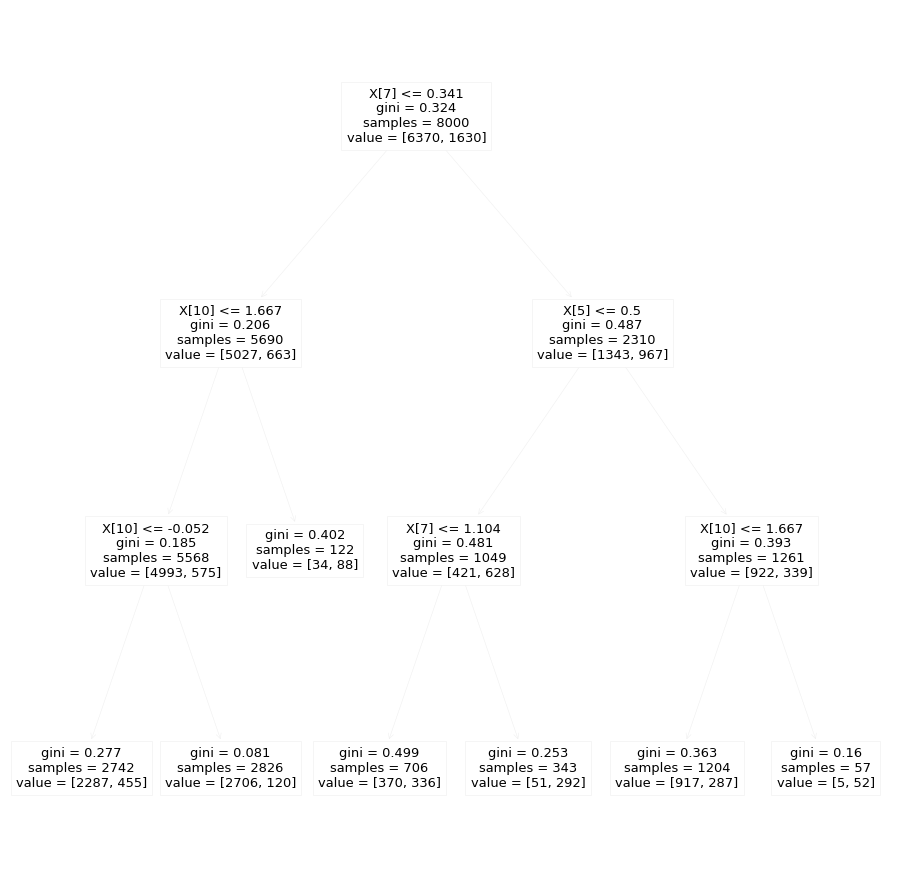

In [335]:
# Plotting the tree
plt.figure(figsize=(16,16))
plot_tree(model_dt)

## <font size="3"> Comparing criterions:</font>

0.000625
0.05322368421052631
0.10582236842105262
0.15842105263157896
0.21101973684210526
0.26361842105263156
0.31621710526315794
0.3688157894736842
0.42141447368421053
0.4740131578947368
0.5266118421052631
0.5792105263157895
0.6318092105263159
0.684407894736842
0.7370065789473684
0.7896052631578947
0.8422039473684211
0.8948026315789473
0.9474013157894736
1.0


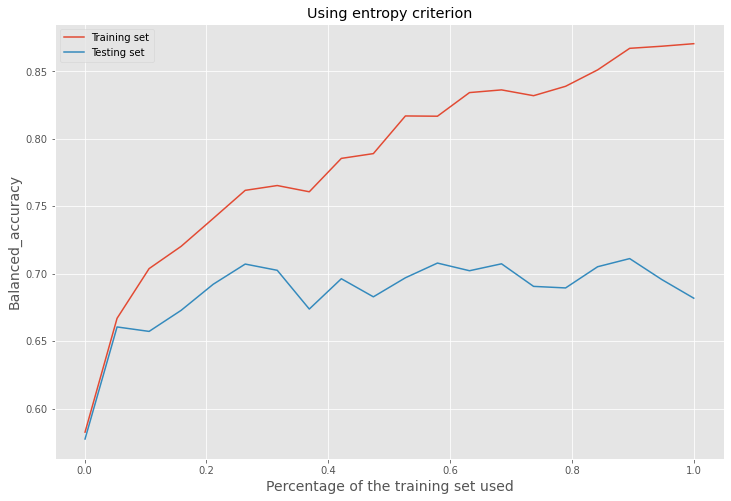

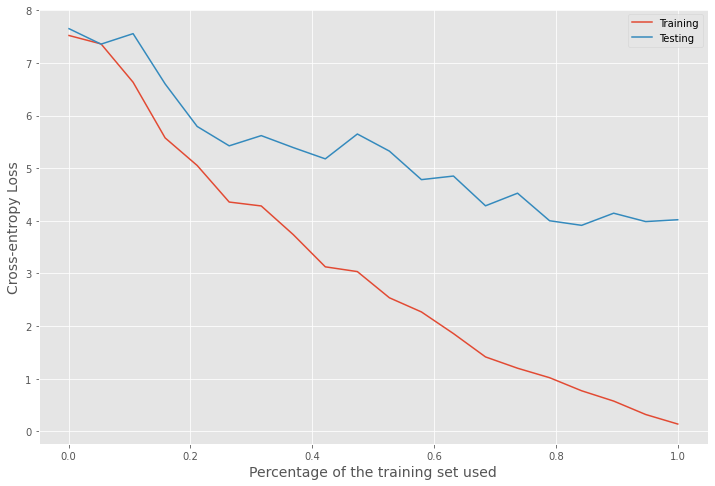

In [355]:
training_curve("dt_entropy", X_train, y_train, X_test, y_test, num_points=20, metric="bal_acc")

0.000625
0.05322368421052631
0.10582236842105262
0.15842105263157896
0.21101973684210526
0.26361842105263156
0.31621710526315794
0.3688157894736842
0.42141447368421053
0.4740131578947368
0.5266118421052631
0.5792105263157895
0.6318092105263159
0.684407894736842
0.7370065789473684
0.7896052631578947
0.8422039473684211
0.8948026315789473
0.9474013157894736
1.0


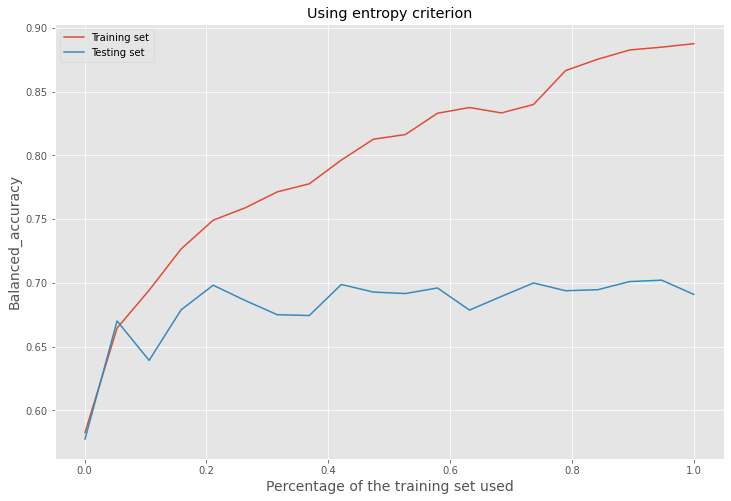

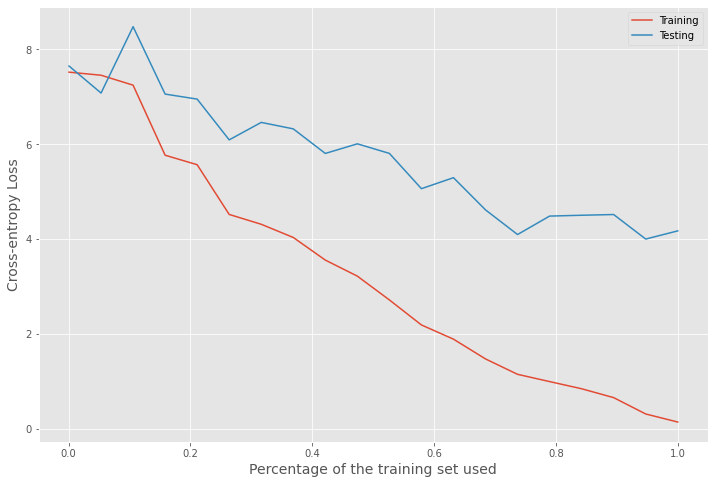

In [356]:
training_curve("dt_gini", X_train, y_train, X_test, y_test, num_points=20, metric="bal_acc")

<font size="3"> The <b>'gini'</b> criterion works a little bit better than the <b>'entropy'</b>. Now let's do a GridSearch in order to find the best values for max_depth and min_samples_split:</font>

In [386]:
max_depth_values = np.arange(2, 15, 2)
min_samples_split_values = [2, 10, 20, 50, 100]

df_result = np.zeros((len(max_depth_values), len(min_samples_split_values)))

for ind_max_depth in range(len(max_depth_values)):
    for ind_min_samples in range(len(min_samples_split_values)):

        print(ind_max_depth)
        scoring = ['balanced_accuracy']
        clf = DecisionTreeClassifier(criterion="gini",
                                     max_depth=max_depth_values[ind_max_depth],
                                     min_samples_split=min_samples_split_values[ind_min_samples],
                                     random_state=1)

        scores = cross_validate(clf, X_train, y_train.astype(int), scoring=scoring, cv=3)
        mean_score = scores['test_balanced_accuracy'].mean()
        df_result[ind_max_depth, ind_min_samples] = mean_score

print(df_result)

0
0
0
0
0
0
1
1
1
1
1
1
[[0.6807904  0.6807904  0.6807904  0.6807904  0.6807904  0.6807904 ]
 [0.68930772 0.69783753 0.70221897 0.71356177 0.72545687 0.6933627 ]]


<font size="3"> The highest value corresponds to  <b>max_depth=10</b> and <b>min_samples_split=100</b>. Let's create our model using those values.</font>

Balanced accuracy:  0.7147617571346385
Test Set:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1593
           1       0.71      0.48      0.57       407

    accuracy                           0.85      2000
   macro avg       0.79      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000

[[1514   79]
 [ 212  195]]


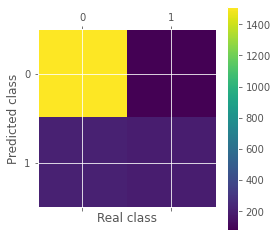

In [389]:
# Create Decision Tree classifer object
model_dt = DecisionTreeClassifier(max_depth=10, random_state=10, min_samples_split=100, criterion="gini")

# Train Decision Tree Classifer
model_dt = model_dt.fit(X_train, y_train.astype(int))

# Predict the response for test dataset
y_pred_dt = model_dt.predict(X_test)
print("Balanced accuracy: ", balanced_accuracy_score(y_test.astype(int), y_pred_dt))


report = classification_report(y_true=y_test.astype(int), y_pred=y_pred_dt)
matrix = confusion_matrix(y_true=y_test.astype(int), y_pred=y_pred_dt)
print("Test Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel("Real class")
plt.ylabel("Predicted class")
plt.show()

<font size="3"><b>Pruning:</b></font>

[0.6738502755451907, 0.7047818234258912, 0.7029795589117623, 0.6874578738985518, 0.7060373162068078, 0.7060373162068078, 0.7060373162068078, 0.7060373162068078, 0.7060373162068078, 0.6325431749160563, 0.6325431749160563, 0.6325431749160563, 0.6325431749160563, 0.6165726589455403, 0.6165726589455403, 0.6165726589455403, 0.6165726589455403, 0.6875187976882893, 0.6875187976882893, 0.6875187976882893, 0.6875187976882893, 0.6875187976882893, 0.6875187976882893, 0.651632371971355, 0.651632371971355, 0.651632371971355, 0.651632371971355, 0.651632371971355, 0.651632371971355, 0.651632371971355, 0.651632371971355, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


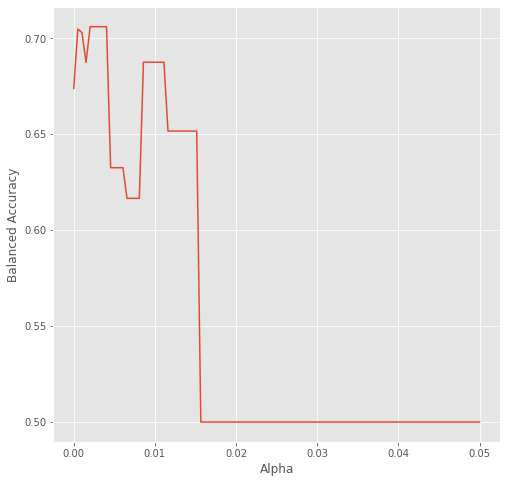

In [408]:
alpha_values = np.linspace(0, 0.05, 100)
df_result = []

for alpha in alpha_values:
    scoring = ['balanced_accuracy']
    clf = DecisionTreeClassifier(criterion="gini",
                                 ccp_alpha=alpha,
                                 random_state=10)
    clf.fit(X_train, y_train.astype(int))
    y_pred=clf.predict(X_test)
    score = balanced_accuracy_score(y_test.astype(int), y_pred)
    df_result.append(score)

plt.figure(figsize=(8,8))
plt.xlabel("Alpha")
plt.ylabel("Balanced Accuracy")
plt.plot(alpha_values, df_result)
print(df_result)

<a id='8'></a>
## Artificial Neural network 

## <font size="3"> Defining the model :</font>

In [459]:
seed(1)
# Initialising the ANN
model_ann = keras.models.Sequential()

# Adding the input layer and the first hidden layer
model_ann.add(Dense(units = 8, activation = 'relu', input_dim = X_train.shape[1]))

# Adding a dropout
model_ann.add(Dropout(0.1, seed=5))

# Adding the second hidden layer
model_ann.add(Dense(units = 4, activation = 'relu'))

# Adding a dropout
model_ann.add(Dropout(0.1, seed=5))

# Adding the output layer
model_ann.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the ANN
optimizer= Adam(
    learning_rate=0.01
)

model_ann.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])


<font size="3"> Some remarks : 
- I chose the number of hidden layers' units to be the average of the input and the output layers.
- Since we want a probability outcome, the last layer unit's activation should be a sigmoid. </font>

## <font size="3"> Fitting and testing the model with the imbalanced data :</font>

In [460]:
# Fix seed
seed(10)

# Fit the model
hist = model_ann.fit(X_train, y_train.astype(float), batch_size=32, epochs=100, shuffle=False,
                     validation_data=(X_test, y_test.astype(int)))


Epoch 1/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4626 - binary_accuracy: 0.7962 - val_loss: 0.4260 - val_binary_accuracy: 0.7965
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4379 - binary_accuracy: 0.7962 - val_loss: 0.4214 - val_binary_accuracy: 0.7965
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4341 - binary_accuracy: 0.7984 - val_loss: 0.4179 - val_binary_accuracy: 0.7965
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4334 - binary_accuracy: 0.8112 - val_loss: 0.4165 - val_binary_accuracy: 0.8160
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4311 - binary_accuracy: 0.8249 - val_loss: 0.4156 - val_binary_accuracy: 0.8270
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4301 - binary_accuracy: 0.8257 - val_loss: 0.4104 - val_binary_accuracy: 0.8285
Epoch 7/100
250/250 [==============================] - 0s 

Epoch 53/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4168 - binary_accuracy: 0.8330 - val_loss: 0.4003 - val_binary_accuracy: 0.8370
Epoch 54/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4198 - binary_accuracy: 0.8376 - val_loss: 0.4002 - val_binary_accuracy: 0.8380
Epoch 55/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4230 - binary_accuracy: 0.8338 - val_loss: 0.4018 - val_binary_accuracy: 0.8345
Epoch 56/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4175 - binary_accuracy: 0.8340 - val_loss: 0.4016 - val_binary_accuracy: 0.8335
Epoch 57/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4200 - binary_accuracy: 0.8342 - val_loss: 0.4016 - val_binary_accuracy: 0.8335
Epoch 58/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4190 - binary_accuracy: 0.8345 - val_loss: 0.4018 - val_binary_accuracy: 0.8360
Epoch 59/100
250/250 [==============================

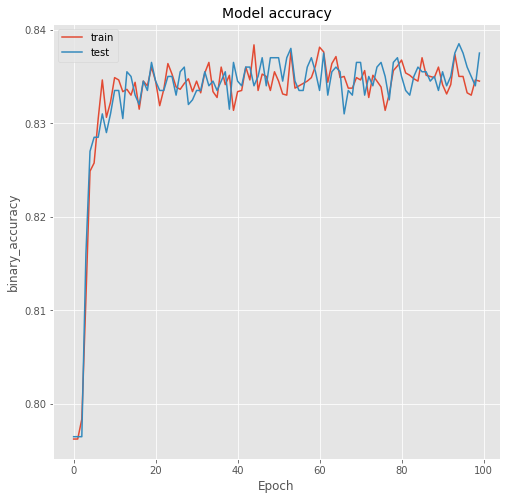

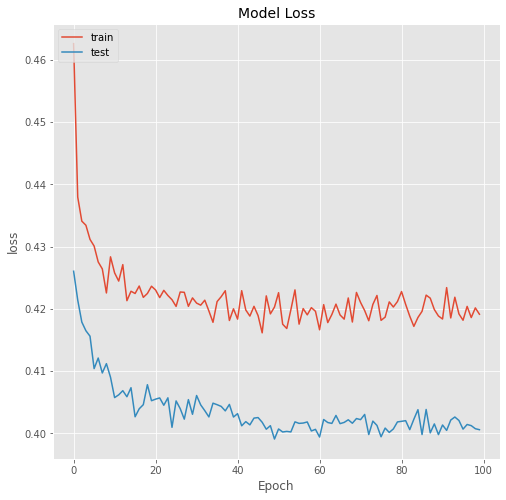

In [461]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(hist.history['binary_accuracy'])
plt.plot(hist.history['val_binary_accuracy'])
plt.title('Model accuracy',{"fontsize" : 14})
plt.ylabel('binary_accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Figure for loss 
plt.figure(figsize=(8,8))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model Loss", {"fontsize" : 14})
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')


Balanced accuracy:  0.6336637099348964
Test Set:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1593
           1       0.77      0.29      0.42       407

    accuracy                           0.84      2000
   macro avg       0.80      0.63      0.66      2000
weighted avg       0.83      0.84      0.81      2000

[[1557   36]
 [ 289  118]]


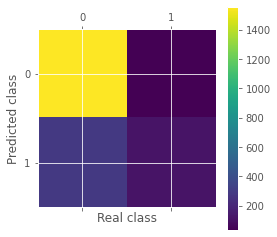

In [501]:
# Predict the response for test dataset
y_pred_ann = model_ann.predict(X_test)>0.5
print("Balanced accuracy: ", balanced_accuracy_score(y_test.astype(int), y_pred_ann))


report = classification_report(y_true=y_test.astype(int), y_pred=y_pred_ann)
matrix = confusion_matrix(y_true=y_test.astype(int), y_pred=y_pred_ann)
print("Test Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel("Real class")
plt.ylabel("Predicted class")
plt.show()

<a id='9'></a>
## Boosting

Using boosting on the previous decision tree:

In [443]:
model_boost = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10, random_state=10, min_samples_split=100, criterion="gini"), 
    n_estimators=100, random_state=1)

model_boost.fit(X_train, y_train.astype(int))

model_boost.predict(X_test)


array([1, 0, 0, ..., 0, 0, 0])

Grid search to determine best number of estimators

Text(0, 0.5, 'Balanced Accuracy')

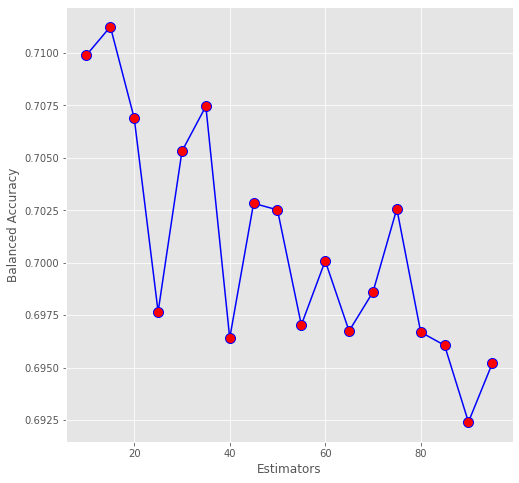

In [450]:
metric_values = []
for i in range(10,100, 5):
    model_boost = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=10, random_state=10, min_samples_split=100, criterion="gini"), 
        n_estimators=i, random_state=1, learning_rate=0.2)
    
    model_boost.fit(X_train,y_train.astype(int))
    pred_boost = model_boost.predict(X_test)
    score = balanced_accuracy_score(y_test.astype(int), pred_boost)
    metric_values.append(score)
    
# Plot the curve
plt.figure(figsize=(8,8))
plt.plot(range(10, 100, 5),metric_values, color="blue",
         marker="o", markerfacecolor="red", markersize=10)
plt.xlabel("Estimators")
plt.ylabel("Balanced Accuracy")
    

Balanced accuracy in function of learning rate:

Text(0, 0.5, 'Balanced Accuracy')

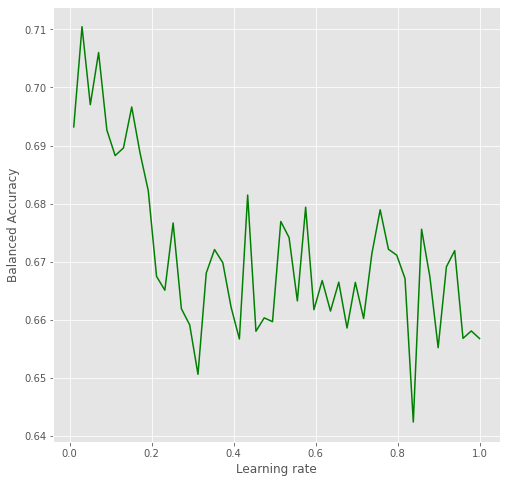

In [457]:
metric_values = []
for i in np.linspace(0.01,1, 50):
    model_boost = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=10, random_state=10, min_samples_split=2, criterion="gini"), 
        n_estimators=10, random_state=1, learning_rate=i)
    model_boost.fit(X_train,y_train.astype(int))
    pred_boost = model_boost.predict(X_test)
    score = balanced_accuracy_score(y_test.astype(int), pred_boost)
    metric_values.append(score)
    
# Plot the curve
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0.01,1,50),metric_values, color="green")
plt.xlabel("Learning rate")
plt.ylabel("Balanced Accuracy")
    

In [505]:
model_boost = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=10, random_state=10, min_samples_split=2, criterion="gini"), 
        n_estimators=15, random_state=1, learning_rate=0.3)
model_boost.fit(X_train,y_train.astype(int))
y_pred_boost = model_boost.predict(X_test)


<a id='10'></a>
## Support Vector Machine

In [207]:
kernels_b = ['linear','rbf','poly','sigmoid']
kernels = ['rbf', 'poly']

<font size="3">Let's try to determine the kernel to use using a 5-Stratified cross-validation:</font>

In [165]:
for kernel in kernels_b:
    scoring = ['balanced_accuracy']
    clf = svm.SVC(kernel=kernel, random_state=0)
    scores = cross_validate(clf, X_train, y_train.astype(int), scoring=scoring, cv=5)
    mean_score = scores['test_balanced_accuracy'].mean()
    print(f"For {kernel} kernel, the mean balanced accuracy is {mean_score:.4f}")


For linear kernel, the mean balanced accuracy is 0.5000
For rbf kernel, the mean balanced accuracy is 0.6821
For poly kernel, the mean balanced accuracy is 0.6704
For sigmoid kernel, the mean balanced accuracy is 0.5421


<font size="3">Tuning parameters for the rbf kernel (gamma and C):</font>

In [174]:
gamma_values = [0.001, 0.01, 0.1, 1]
C_values = [0.1, 1, 5, 10]

df_result = np.zeros((len(gamma_values), len(C_values)))

for ind_gamma in range(len(gamma_values)):
    for ind_C in range(len(C_values)):
        scoring = ['balanced_accuracy']
        clf = svm.SVC(kernel='rbf', random_state=0, C=C_values[ind_C], gamma=gamma_values[ind_gamma])
        scores = cross_validate(clf, X_train, y_train.astype(int), scoring=scoring, cv=3)
        mean_score = scores['test_balanced_accuracy'].mean()
        df_result[ind_gamma, ind_C] = mean_score

print(df_result)

[[0.5        0.5        0.5        0.5       ]
 [0.5        0.51349732 0.60051108 0.64760223]
 [0.56322073 0.6814065  0.7009565  0.70489415]
 [0.5        0.6092935  0.62774283 0.62391615]]


<font size="3"> The highest value corresponds to <b>gamma=0.1</b> and <b>C=5</b></font>. Using those values, let's build our classifier !

Test Set:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1593
           1       0.83      0.44      0.58       407

    accuracy                           0.87      2000
   macro avg       0.85      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000

[[1555   38]
 [ 226  181]]


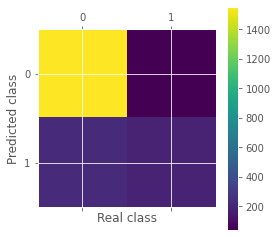

In [481]:
model_svm = svm.SVC(kernel='rbf', gamma=0.1, C=5, probability=True)
model_svm.fit(X_train, y_train.astype(int))
y_pred = model_svm.predict_proba(X_test)
report = classification_report(y_true=y_test.astype(int),y_pred=y_pred[:,1]>=0.5)
matrix = confusion_matrix(y_true=y_test.astype(int),y_pred=y_pred[:,1]>=0.5)
print("Test Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel("Real class")
plt.ylabel("Predicted class")
plt.show()

<font size="3"> The highest value corresponds to <b>gamma=0.1</b> and <b>C=5</b></font>. Using those values, let's build our classifier !

0.000625
0.05322368421052631
0.10582236842105262
0.15842105263157896
0.21101973684210526
0.26361842105263156
0.31621710526315794
0.3688157894736842
0.42141447368421053
0.4740131578947368
0.5266118421052631
0.5792105263157895
0.6318092105263159
0.684407894736842
0.7370065789473684
0.7896052631578947
0.8422039473684211
0.8948026315789473
0.9474013157894736
1.0


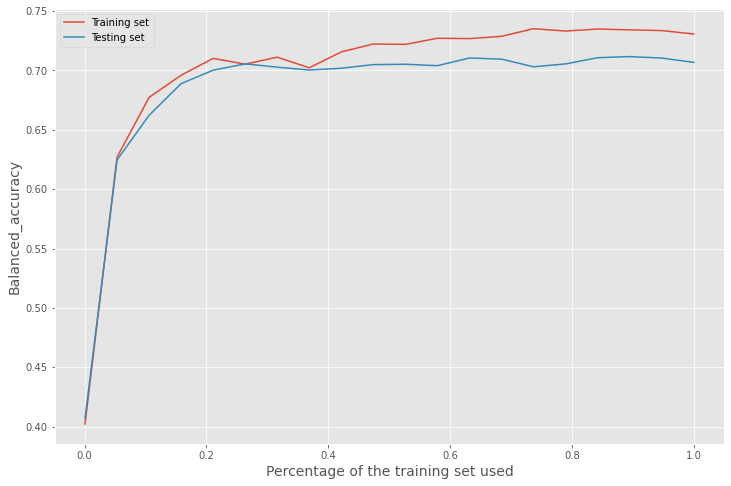

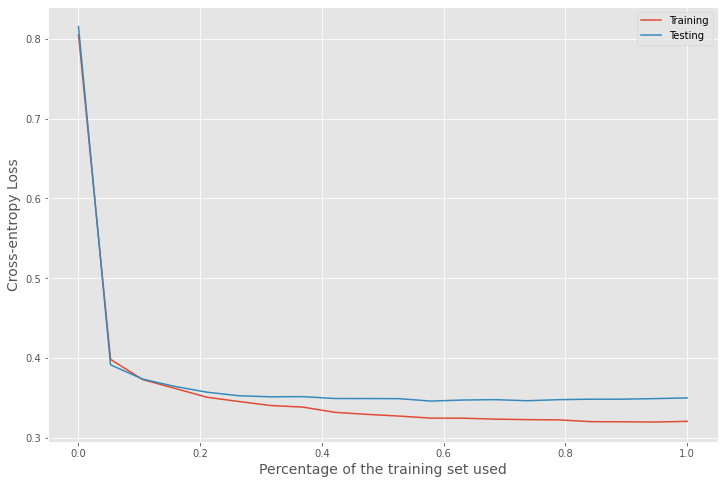

In [206]:
training_curve("svm_rbf", X_train, y_train, X_test, y_test, num_points=20, metric="bal_acc")

<font size="3">Tuning parameters for polynomial kernel:</font>

In [225]:
gamma_values = [0.01, 0.1]
C_values = [0.1, 1, 5]
degree_values = [3, 5, 7]
coef0_values = [0, 1, 2]

df_result = np.zeros((len(gamma_values), len(C_values), len(degree_values)))

for ind_gamma in range(len(gamma_values)):
    for ind_C in range(len(C_values)):
        for ind_degree in range(len(degree_values)):
                print(ind_degree)
                scoring = ['balanced_accuracy']
                clf = svm.SVC(kernel='poly', random_state=0, C=C_values[ind_C],
                              gamma=gamma_values[ind_gamma], degree=degree_values[ind_degree], coef0=2)
                scores = cross_validate(clf, X_train, y_train.astype(int), scoring=scoring, cv=3)
                mean_score = scores['test_balanced_accuracy'].mean()
                df_result[ind_gamma, ind_C, ind_degree] = mean_score

print(df_result)

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
[[[0.51349732 0.58993317 0.67636937]
  [0.56793334 0.67767562 0.69076727]
  [0.66322168 0.68283815 0.70480366]]

 [[0.6736871  0.70684602 0.69448382]
  [0.69526731 0.70940246 0.68656204]
  [0.70578783 0.70315695 0.67780717]]]


0.000625
0.05322368421052631
0.10582236842105262
0.15842105263157896
0.21101973684210526
0.26361842105263156
0.31621710526315794
0.3688157894736842
0.42141447368421053
0.4740131578947368
0.5266118421052631
0.5792105263157895
0.6318092105263159
0.684407894736842
0.7370065789473684
0.7896052631578947
0.8422039473684211
0.8948026315789473
0.9474013157894736
1.0


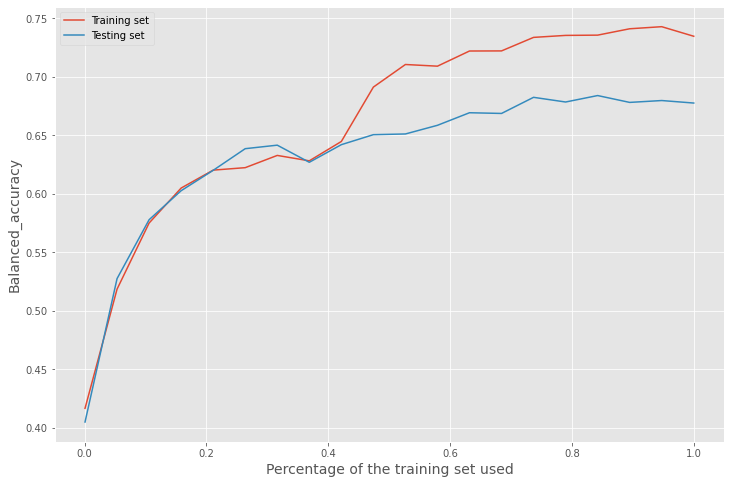

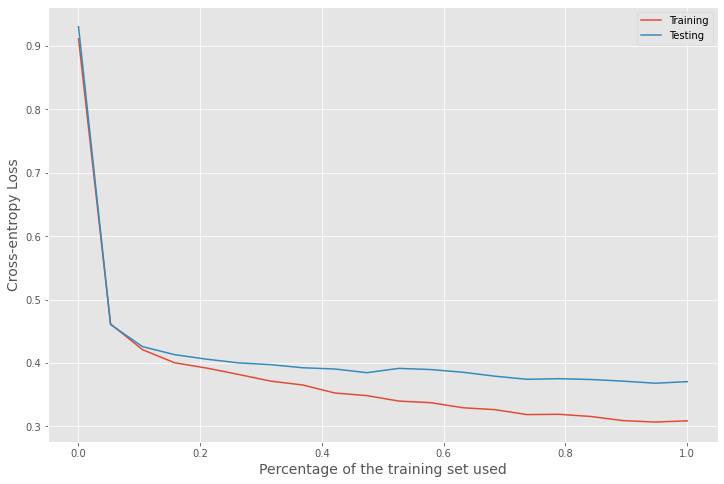

In [227]:
training_curve("svm_poly", X_train, y_train, X_test, y_test, num_points=20, metric="bal_acc")

<a id='11'></a>
## k-Nearest neighbors

Elbow method:

In [413]:
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train.astype(int))
model_knn.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

Text(0, 0.5, 'Error Rate')

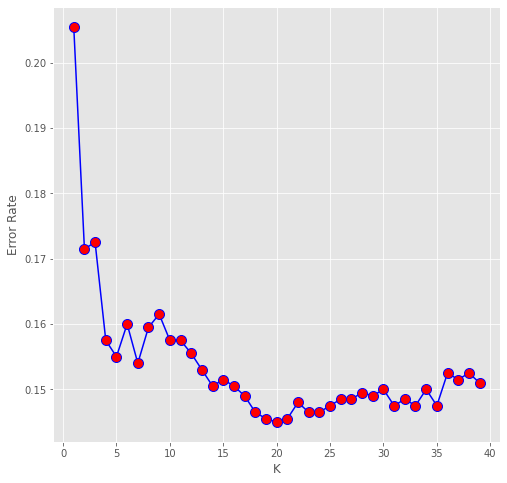

In [425]:
# Calculate error rates for several values of k
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train.astype(int))
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
# Plot the curve
plt.figure(figsize=(8,8))
plt.plot(range(1,40),error_rate, color="blue",
         marker="o", markerfacecolor="red", markersize=10)
plt.xlabel("K")
plt.ylabel("Error Rate")
    

Comparing distances:

0.0025
0.055
0.1075
0.16
0.2125
0.265
0.3175
0.37
0.4225
0.475
0.5275
0.58
0.6325
0.685
0.7375
0.79
0.8425
0.895
0.9475
1.0


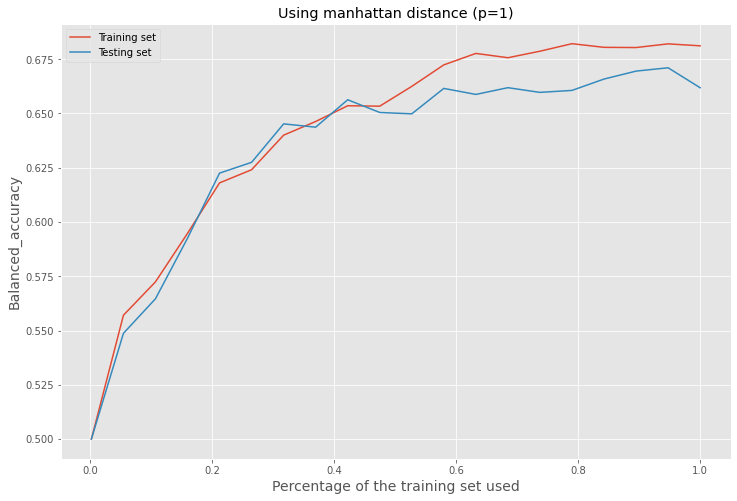

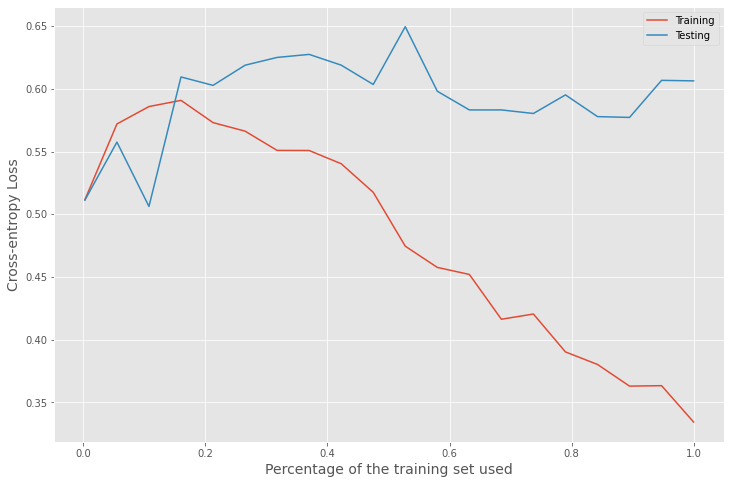

In [435]:
training_curve("knn_manhattan", X_train, y_train, X_test, y_test, smallest_size=20, num_points=20, 
               metric="bal_acc", title="Using manhattan distance (p=1)")

0.0025
0.055
0.1075
0.16
0.2125
0.265
0.3175
0.37
0.4225
0.475
0.5275
0.58
0.6325
0.685
0.7375
0.79
0.8425
0.895
0.9475
1.0


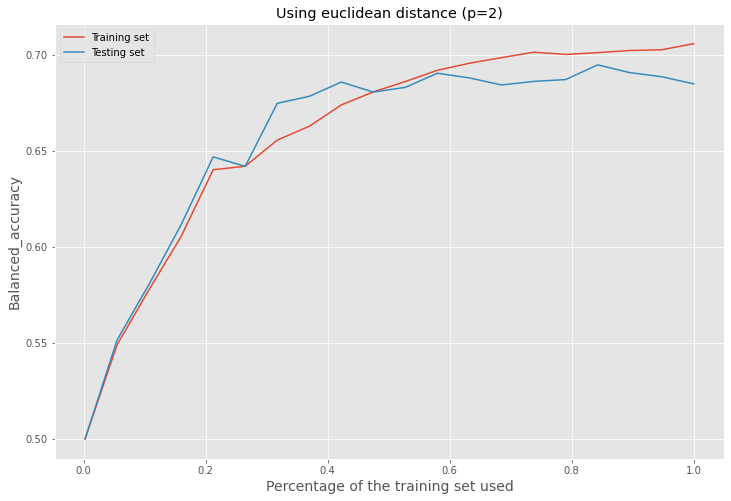

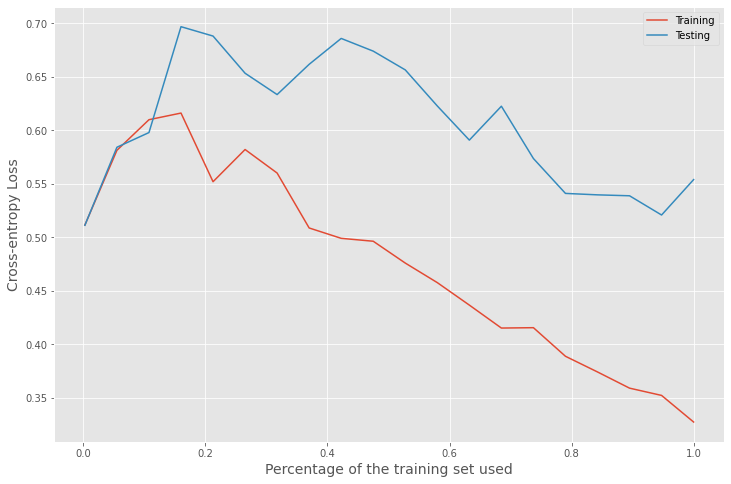

In [436]:
training_curve("knn_euclidean", X_train, y_train, X_test, y_test, smallest_size=20, num_points=20, 
               metric="bal_acc", title="Using euclidean distance (p=2)")

0.0025
0.055
0.1075
0.16
0.2125
0.265
0.3175
0.37
0.4225
0.475
0.5275
0.58
0.6325
0.685
0.7375
0.79
0.8425
0.895
0.9475
1.0


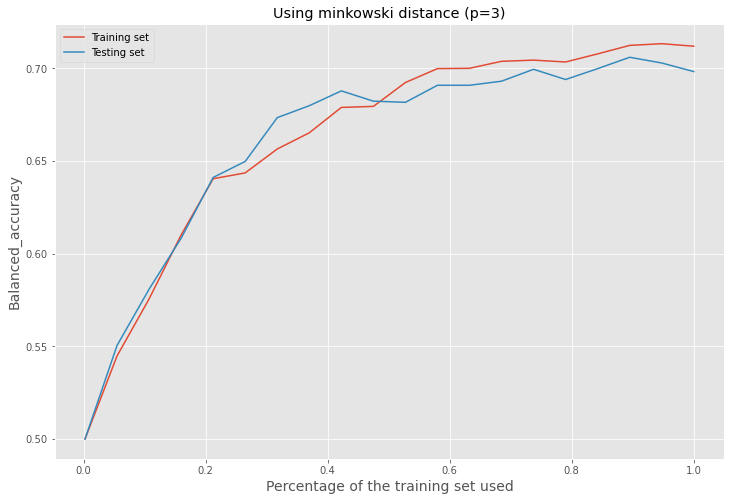

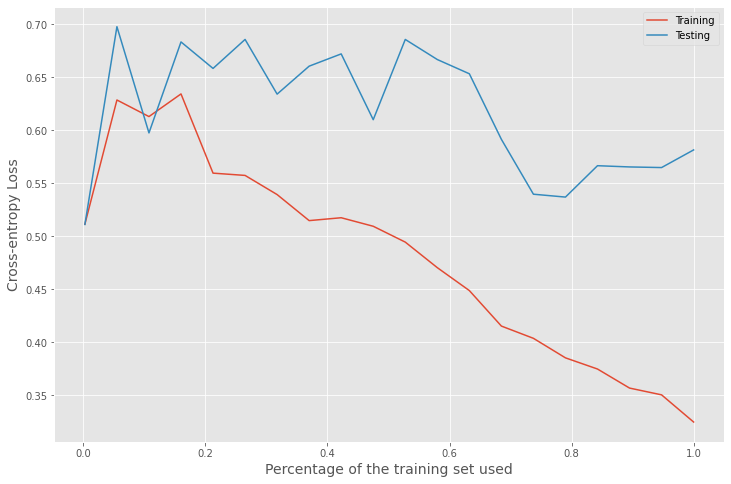

In [438]:
training_curve("knn_minkowski3", X_train, y_train, X_test, y_test, smallest_size=20, num_points=20, 
               metric="bal_acc", title="Using minkowski distance (p=3)")

<a id='12'></a>
## Comparing the results

In [ ]:
lr_probs = model_dt.predict_proba(X_test)[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test.astype(int), lr_probs)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(lr_fpr, lr_tpr, marker='+', label='µgistic')

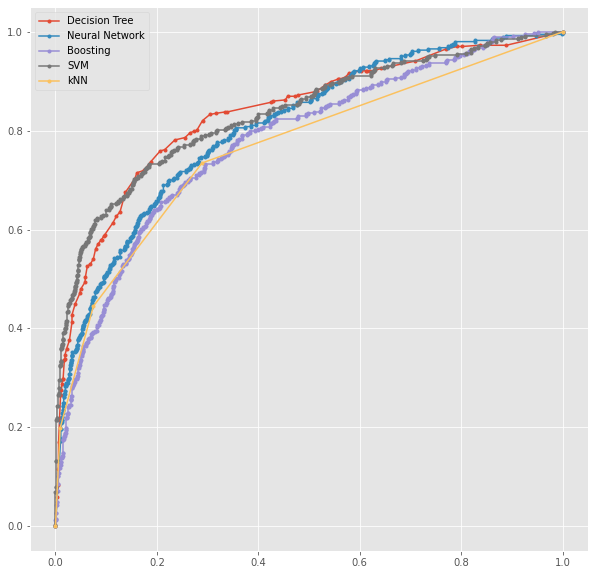

In [508]:
plt.figure(figsize=(10,10))
# ROC curve of decision tree
dt_proba = model_dt.predict_proba(X_test)[:,1]
dt_fpr, dt_tpr, _ = roc_curve(y_test.astype(int), dt_proba)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')

# ROC curve of neural networks
nn_proba = model_ann.predict_proba(X_test)
nn_fpr, nn_tpr, _ = roc_curve(y_test.astype(int), nn_proba)
plt.plot(nn_fpr, nn_tpr, marker='.', label='Neural Network')

# ROC curve of boosting
boost_proba = model_boost.predict_proba(X_test)[:,1]
boost_fpr, boost_tpr, _ = roc_curve(y_test.astype(int), boost_proba)
plt.plot(boost_fpr, boost_tpr, marker='.', label='Boosting')

# ROC curve of SVM
svm_proba = model_svm.predict_proba(X_test)[:,1]
svm_fpr, svm_tpr, _ = roc_curve(y_test.astype(int), svm_proba)
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')

# ROC curve of knn
knn_proba = model_knn.predict_proba(X_test)[:,1]
knn_fpr, knn_tpr, _ = roc_curve(y_test.astype(int), knn_proba)
plt.plot(knn_fpr, knn_tpr, marker='.', label='kNN')


plt.legend()



In [487]:
print(f"AUC value of decision tree: {auc(dt_fpr, dt_tpr)}")
print(f"AUC value of neural network: {auc(nn_fpr, nn_tpr)}")
print(f"AUC value of boosting: {auc(boost_fpr, boost_tpr)}")
print(f"AUC value of svm: {auc(svm_fpr, svm_tpr)}")
print(f"AUC value of knn: {auc(knn_fpr, knn_tpr)}")

AUC value of decision tree: 0.8360903276157513
AUC value of neural network: 0.8075085871696042
AUC value of boosting: 0.7532447701939227
AUC value of svm: 0.8355304456999373
AUC value of knn: 0.765049332845943
